In [1]:
# Specify quail source directory
source_dir = r"C:\Users\Fredric\Documents\Volcano\quail_volcano\src"

In [2]:
# Import standard libraries
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
# Import steady_state module
os.chdir(source_dir)
import compressible_conduit_steady.steady_state as steady_state

Top pressure in numerical solution is 100000.0 Pa.
Bottom pressure in numerical solution is 45160219.50736791 Pa.


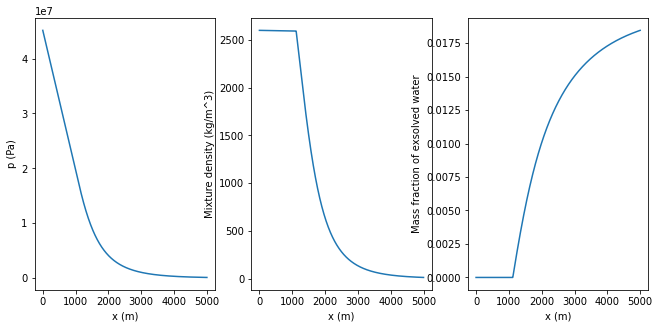

In [4]:
# Construct x_mesh (with shape (n, 1, 1))
N_mesh_points = 1000
x_mesh = np.linspace(0, 5000, N_mesh_points)[:,np.newaxis,np.newaxis]
# Chamber pressure is not used, so we pass a dummy value
p_chamber = None
# Set vent pressure
p_vent = 1e5
# Set functions for traction, total water mass fraction, crystal mass fraction, temperature
#   Functions zeros_like and ones_like are 0 and 1, but broadcasted to the same shape as x
traction_fn = lambda x: np.zeros_like(x)
yWt_fn = lambda x: 0.02 * np.ones_like(x)
yC_fn = lambda x: 0.2 * np.zeros_like(x)
T_fn = lambda x: 1050 * np.ones_like(x)
# Set material properties of the magma phase (melt + dissolved water + crystals)
material_props = {
  "yA": 1e-7,          # Air mass fraction (> 0 for numerics)
  "c_v_magma": 3e3,    # Magma phase heat capacity per mass
  "rho0_magma": 2.6e3, # Linearization reference density
  "K_magma": 10e9,     # Bulk modulus
  "p0_magma": 36e6,    # Linearization reference pressure
  "solubility_k": 5e-6, # Henry's law coefficient
  "solubility_n": 0.5, # Henry's law exponent
}

# Initialize hydrostatic steady-state solver
# This is a one-use callable object
f = steady_state.StaticPlug(x_mesh,
                            p_chamber,
                            traction_fn, yWt_fn, yC_fn, T_fn,
                            override_properties=material_props, enforce_p_vent=p_vent)
# Solve by calling f
#   io_format="p" here returns only pressure
#   io_format="quail" will return the solution in quail format
p = f(x_mesh, is_solve_direction_downward=True, io_format="p")

# Solve again in Quail format (need to reinitialize f)
f = steady_state.StaticPlug(x_mesh,
                            p_chamber,
                            traction_fn, yWt_fn, yC_fn, T_fn,
                            override_properties=material_props, enforce_p_vent=p_vent)
U = f(x_mesh, is_solve_direction_downward=True, io_format="quail")

# ravel() smooshes the dimension of the data into a 1-D vector for plotting
plt.figure(figsize=(11,5))
plt.subplot(1,3,1)
plt.plot(x_mesh.ravel(), p.ravel())
plt.xlabel("x (m)")
plt.ylabel("p (Pa)")

# Here we work with the quail-formatted data
plt.subplot(1,3,2)
rho = U[...,0:3].sum(axis=-1, keepdims=True)
plt.plot(x_mesh.ravel(), rho.ravel())
plt.xlabel("x (m)")
plt.ylabel("Mixture density (kg/m^3)")

plt.subplot(1,3,3)
plt.plot(x_mesh.ravel(), (U[...,1:2]/rho).ravel())
plt.xlabel("x (m)")
plt.ylabel("Mass fraction of exsolved water")

print(f"Top pressure in numerical solution is {p.ravel()[-1]} Pa.")
print(f"Bottom pressure in numerical solution is {p.ravel()[0]} Pa.")
